In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [17]:
# Mål: Gjør binary classification på om dem e disease free nå

cancer_type_columns = [
#    "Neoplasm Disease Stage American Joint Committee on Cancer Code", 
   "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage", # Denne hjalp
# #    "American Joint Committee on Cancer Metastasis Stage Code", 
# #    "American Joint Committee on Cancer Lymph Node Stage Code.1", 
   "American Joint Committee on Cancer Lymph Node Stage Code", # Denne hjalp
   "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code", # Denne hjalp
# #    "Neoplasm Disease Stage American Joint Committee on Cancer Code.1", 
   "American Joint Committee on Cancer Publication Version Type", # Har mye å si
# #    "American Joint Committee on Cancer Tumor Stage Code",
#    "Cancer Type Detailed", # Bidrar ikke positivt
#    "Fraction Genome Altered", # Bidrar litt positivt
   "Mutation Count", # Bidrar positivt
    "Sample Initial Weight", # Hjalp veldig
    # "TMB (nonsynonymous)", # Hjalp ikkje
]

pd_df_original = pd.read_csv(
    "./Expanded TCD.csv",
    # names=[*cancer_type_columns, "Disease Free (Months)"]
    usecols=[*cancer_type_columns, 'Disease Free (Months)', 'Postoperative tx', 'Disease Free Status'],
    na_values=['NA'],
    keep_default_na=False
)

prevLength = len(pd_df_original)

pd_df_original = pd_df_original.dropna()

print(f'Dropped {prevLength - len(pd_df_original)} values, leaving us with {len(pd_df_original)}')

for column in cancer_type_columns:
    domain = dict.fromkeys(pd_df_original[column].unique().tolist())
    for value in domain:
        domain[value] = (pd_df_original[column] == value).sum()
    print(f'    Column "{column}"', domain)

pd_df = pd_df_original.copy()
# pd_df = pd_df.loc[pd_df['Disease Free Status'] == '1:Recurred/Progressed']

# target = pd_df.apply(lambda p: p['Disease Free (Months)'] * (1 if p['Disease Free Status'] == '1:Recurred/Progressed' else 2), axis=1)

target = pd_df.pop('Disease Free Status')

target = target.replace('1:Recurred/Progressed', 1)
target = target.replace('0:DiseaseFree', 0)
# pd_df.pop('Disease Free Status')

# target = np.log10(target)

inputs = {}

numericInputsBool = False

for name, column in pd_df.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        numericInputsBool = True
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)


if numericInputsBool:
    # Vi har ingen numeric inputs pr no
    numeric_inputs = {name:input for name,input in inputs.items()
                    if input.dtype==tf.float32}
    x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = tf.keras.layers.Normalization()
    norm.adapt(np.array(pd_df_original[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]
else:
    preprocessed_inputs = []

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(pd_df[name]))
    one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

# preprocessed_inputs

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# Nå visualiserings greie
# tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


# Split training og testing data
# Random state 5 e dårlig, 19 og 4 e ganske bra, 2 e hinsides bra!
random_state=2

train_input, test_input = train_test_split(pd_df, test_size=0.2, random_state=random_state)
train_output, test_output = train_test_split(target, test_size=0.2, random_state=random_state)

train_input = {name: np.array(value) for name, value in train_input.items()}
test_input = {name: np.array(value) for name, value in test_input.items()}

# Must split my_features_dict into training and testing data
# Split on the same indexes with target, my_features_dict[0] corresponds to target[0] and so on

def model_func(preprocessing, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2) 
    ])

    # Det e ingen outputs som er lavere enn null, så vi kan trygt bruk activation function relu på output


    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(4, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dense(1)

    preprocessed_inputs = preprocessing(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.legacy.Adam()
    )
    return model

model = model_func(preprocessing, inputs)

print(f'Training set length: {len(train_output)}, Test set length: {len(test_output)}')

Dropped 133 values, leaving us with 608
    Column "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage" {'M0': 589, 'M1a': 19}
    Column "American Joint Committee on Cancer Lymph Node Stage Code" {'T1': 361, 'T2': 247}
    Column "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code" {'N0': 418, 'NX': 190}
    Column "American Joint Committee on Cancer Publication Version Type" {'7th': 171, '6th': 285, '5th': 114, '4th': 38}
    Column "Mutation Count" {41.0: 19, 46.0: 57, 66.0: 76, 68.0: 19, 59.0: 57, 42.0: 19, 67.0: 19, 54.0: 19, 57.0: 19, 79.0: 19, 56.0: 19, 73.0: 19, 69.0: 19, 48.0: 57, 49.0: 19, 58.0: 38, 53.0: 19, 25.0: 19, 62.0: 19, 51.0: 19, 47.0: 19, 43.0: 19}
    Column "Sample Initial Weight" {290.0: 38, 280.0: 57, 350.0: 19, 260.0: 19, 200.0: 38, 220.0: 19, 165.0: 19, 240.0: 19, 210.0: 38, 380.0: 19, 310.0: 38, 600.0: 19, 320.0: 19, 550.0: 19, 180.0: 19, 270.0: 19, 160.0: 19, 440.0: 19, 430.0: 19, 50.0: 19, 150.0: 19, 40.0:

(0.6491955518722534, 0.6283732056617737)
(0.6455265879631042, 0.6240959763526917)
(0.6427298784255981, 0.6181853413581848)
(0.6413223743438721, 0.6174213290214539)
(0.6390886902809143, 0.6279298067092896)
(0.6425955295562744, 0.6190440654754639)
(0.6270895004272461, 0.6206977367401123)
(0.6368616223335266, 0.6242106556892395)
(0.644812285900116, 0.6397913694381714)
(0.6374014019966125, 0.6230700612068176)
(0.6393852829933167, 0.620538592338562)
(0.6444737911224365, 0.6215577125549316)
(0.6478358507156372, 0.625734806060791)
(0.629159152507782, 0.6010866165161133)
(0.6379804611206055, 0.6183675527572632)
(0.6420707702636719, 0.6296524405479431)
(0.640825629234314, 0.6292790174484253)
(0.6458805203437805, 0.6267676949501038)
(0.6488469839096069, 0.6252515316009521)
(0.640911877155304, 0.6257339119911194)
(0.6523677706718445, 0.6341822743415833)
(0.6452183723449707, 0.6258202195167542)
(0.6456331610679626, 0.6258631348609924)
(0.6427507400512695, 0.617031991481781)
(0.6419084668159485, 0.

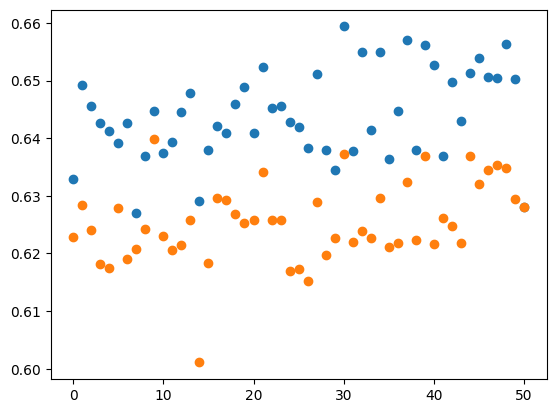

In [19]:
results = []

results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
for i in range(50):
    model.fit(x=train_input, y=train_output, epochs=100, verbose=0)
    results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
    print(results[-1])

fig, ax = plt.subplots()
ax.plot([r[0] for r in results], 'o')
ax.plot([r[1] for r in results], 'o')

print(results[-1][1])

plt.show()